# iSLAT Data Types Tutorial

This notebook demonstrates how to use the core iSLAT data types independently:
- **MoleculeLineList** - Molecular line data from HITRAN
- **Intensity** - Line intensity calculations
- **Spectrum** - Spectral flux generation with convolution
- **Molecule** - High-level molecule class combining all the above
- **MoleculeDict** - Collection of molecules with summed flux

These classes can be used without the GUI for programmatic analysis.

In [2]:
# First, add the iSLAT package to the Python path
import sys
from pathlib import Path

#Temporary: hardcoding path to iSLATTests directory for now, but will just be able to import iSLAT once it's pip installed

# Navigate from notebook location to the iSLATTests directory (where iSLAT package lives)
notebook_dir = Path.cwd()
# Go up from Notebooks -> Examples -> iSLATTests
islat_root = notebook_dir.parent.parent.parent
if str(islat_root) not in sys.path:
    sys.path.insert(0, str(islat_root))

# Now import the core iSLAT data types
import numpy as np
import matplotlib.pyplot as plt

# Import data types from iSLAT
from iSLAT.Modules.DataTypes import Intensity, Spectrum, Molecule, MoleculeDict
from iSLAT.Modules.DataTypes.MoleculeLineList import MoleculeLineList
from iSLAT.Modules.FileHandling.iSLATFileHandling import read_HITRAN_data, read_default_molecule_parameters

print("iSLAT data types imported successfully!")

iSLAT data types imported successfully!


In [3]:
# Define paths to HITRAN parameter files for the molecules we want to create
data_dir = Path(islat_root) / "iSLAT" / "DATAFILES" / "HITRANdata"

water_par_file = str(data_dir / "data_Hitran_H2O.par")
co_par_file    = str(data_dir / "data_Hitran_CO.par")
co2_par_file   = str(data_dir / "data_Hitran_CO2.par")

## 1. MoleculeLineList - Loading HITRAN Data

The `MoleculeLineList` class holds molecular line data (wavelengths, energies, Einstein A coefficients, etc.) loaded from HITRAN format files.

In [4]:
# Load HITRAN data for H2O
# Create a MoleculeLineList from the HITRAN data
# The MoleculeLineList filters lines to a specific wavelength range for efficiency
wavelength_range = (5.0, 25.0)  # microns

line_list = MoleculeLineList(
    molecule_id="H2O",
    filename=water_par_file
)
    
# Access line properties
print(f"Molecule: {line_list.name}")
print(f"Number of lines in range: {len(line_list.get_wavelengths())}")
print(f"Wavelength range: {line_list.get_wavelengths().min():.2f} - {line_list.get_wavelengths().max():.2f} μm")
print(f"\nFirst 5 line wavelengths: {line_list.get_wavelengths()[:5]}")
print(f"First 5 Einstein A coefficients: {line_list.get_einstein_coefficients()[:5]}")

Molecule: H2O
Number of lines in range: 305561
Wavelength range: 0.30 - 933.28 μm

First 5 line wavelengths: [933.27661 928.2218  926.64453 926.56085 922.00464]
First 5 Einstein A coefficients: [6.177e-06 8.967e-06 2.590e-05 9.288e-06 1.157e-05]


## 2. Intensity - Calculating Line Intensities

The `Intensity` class calculates line intensities based on physical parameters (temperature, column density, line broadening). It implements the slab model equations from Banzatti et al. 2012.

In [5]:
# Create an Intensity calculator from the line list
intensity_calc = Intensity(line_list)

# Set physical parameters and calculate intensities
temperature = 850  # Kelvin
column_density = 1e18  # molecules/cm^2
line_broadening = 1.0  # km/s (Doppler broadening)

# Calculate intensities
intensity_calc.calc_intensity(
    t_kin=temperature,
    n_mol=column_density,
    dv=line_broadening
)

# Access calculated values
print(f"Temperature: {intensity_calc.t_kin} K")
print(f"Column density: {intensity_calc.n_mol:.2e} cm^-2")
print(f"Line broadening: {intensity_calc.dv} km/s")
print(f"\nIntensity array shape: {intensity_calc.intensity.shape}")
print(f"Optical depth (tau) range: {intensity_calc.tau.min():.3f} - {intensity_calc.tau.max():.3f}")

Temperature: 850 K
Column density: 1.00e+18 cm^-2
Line broadening: 1.0 km/s

Intensity array shape: (305561,)
Optical depth (tau) range: 0.000 - 903.896


## 3. Spectrum - Creating Spectral Flux

The `Spectrum` class takes intensity components and generates a flux spectrum by convolving with an instrumental line spread function. It handles the wavelength grid and spectral resolution.

In [6]:
# Create a Spectrum object
# Parameters simulate JWST MIRI-MRS resolution
spectrum = Spectrum(
    lam_min=10.0,           # Start wavelength (μm)
    lam_max=20.0,           # End wavelength (μm)
    dlambda=0.001,          # Wavelength grid spacing (μm)
    R=3000,                 # Spectral resolving power (λ/Δλ)
    distance=160            # Distance to source (pc)
)

# Add the intensity component with an emitting area
emitting_radius = 0.5  # AU
emitting_area = np.pi * emitting_radius**2  # AU^2

spectrum.add_intensity(intensity_calc, emitting_area)

# Get the convolved flux
wavelengths = spectrum.lamgrid
flux_jy = spectrum.flux_jy  # Flux in Jansky

print(f"Spectrum wavelength grid: {len(wavelengths)} points")
print(f"Wavelength range: {wavelengths.min():.2f} - {wavelengths.max():.2f} μm")
print(f"Peak flux: {np.max(flux_jy):.4f} Jy")

Spectrum wavelength grid: 10001 points
Wavelength range: 10.00 - 20.00 μm
Peak flux: 0.1567 Jy


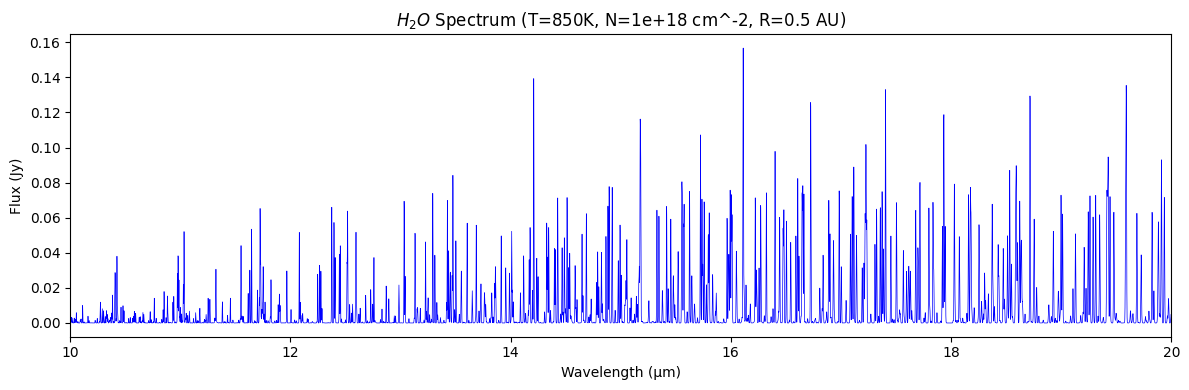

In [7]:
# Plot the spectrum
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(wavelengths, flux_jy, 'b-', linewidth=0.5)
ax.set_xlabel('Wavelength (μm)')
ax.set_ylabel('Flux (Jy)')
ax.set_title(f'$H_2O$ Spectrum (T={temperature}K, N={column_density:.0e} cm^-2, R={emitting_radius} AU)')
ax.set_xlim(10, 20)
plt.tight_layout()
plt.show()

## 4. Molecule - High-Level Molecule Class

The `Molecule` class combines all the above into a convenient high-level interface. It handles HITRAN data loading, intensity calculation, and spectrum generation automatically with intelligent caching.

In [8]:
# Create a Molecule object with all parameters
h2o_molecule = Molecule(
    name="H2O",
    filepath=water_par_file,
    
    # Physical parameters
    temp=850,              # Temperature (K)
    radius=0.5,            # Emitting radius (AU)
    n_mol=1e18,            # Column density (cm^-2)
    distance=160,          # Distance (pc)
    fwhm=130,              # FWHM line width (km/s)
    broad=1.0,             # Intrinsic broadening (km/s)
    
    # Display properties
    displaylabel="H2O",
    color="blue",
    is_visible=True,
    
    # Wavelength range
    wavelength_range=(5.0, 25.0),
    model_pixel_res=0.001
)

print(f"Molecule: {h2o_molecule.name}")
print(f"Temperature: {h2o_molecule.temp} K")
print(f"Column density: {h2o_molecule.n_mol:.2e} cm^-2")
print(f"Emitting radius: {h2o_molecule.radius} AU")
print(f"Distance: {h2o_molecule.distance} pc")

Molecule: H2O
Temperature: 850.0 K
Column density: 1.00e+18 cm^-2
Emitting radius: 0.5 AU
Distance: 160.0 pc


Calculating intensity for H2O: T=850.0K, N_mol=1.00e+18, dv=1.0
Generated spectrum with 20001 points
Wavelength range: 5.00 - 25.00 μm


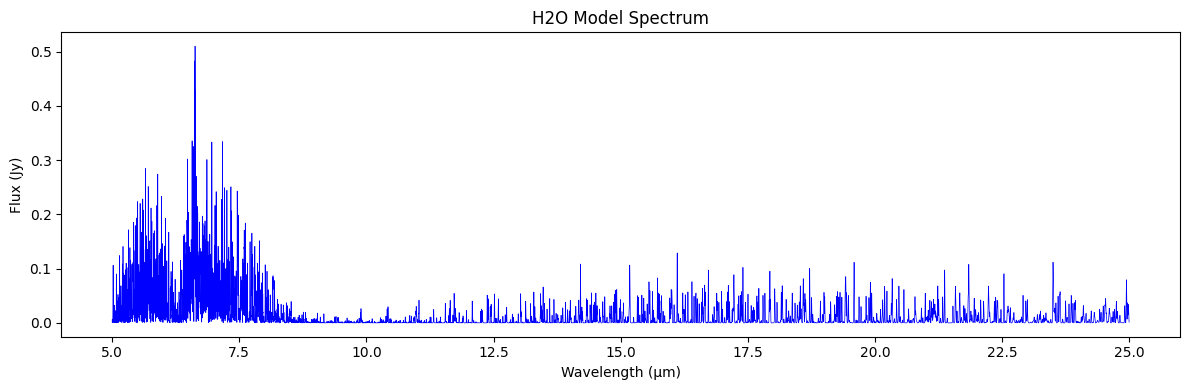

In [9]:
# Get flux from the molecule - this triggers automatic calculation
wave, flux = h2o_molecule.get_flux(return_wavelengths=True)

print(f"Generated spectrum with {len(wave)} points")
print(f"Wavelength range: {wave.min():.2f} - {wave.max():.2f} μm")

# Plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(wave, flux, color=h2o_molecule.color, linewidth=0.5)
ax.set_xlabel('Wavelength (μm)')
ax.set_ylabel('Flux (Jy)')
ax.set_title(f'{h2o_molecule.displaylabel} Model Spectrum')
plt.tight_layout()
plt.show()

Calculating intensity for H2O: T=500.0K, N_mol=5.00e+17, dv=1.0


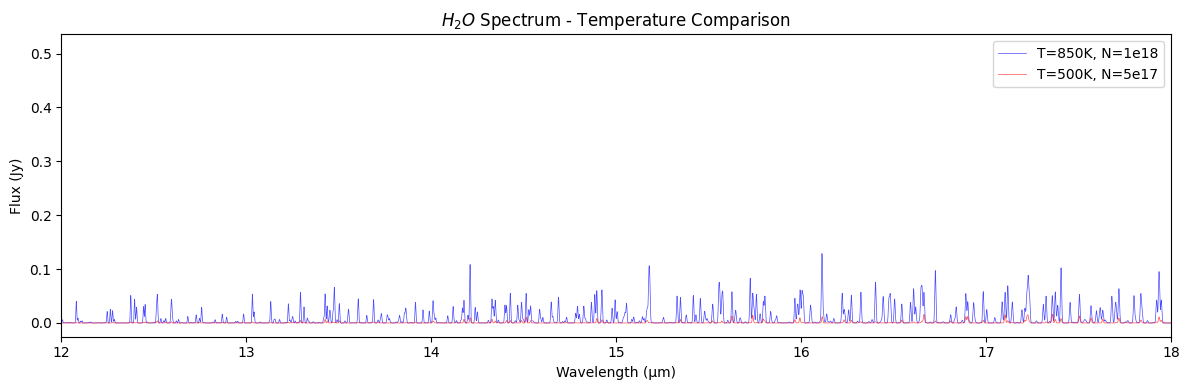

In [10]:
# Modify molecule parameters - caching automatically handles recalculation
h2o_molecule.temp = 500  # Change temperature
h2o_molecule.n_mol = 5e17  # Change column density

# Get updated flux
wave2, flux2 = h2o_molecule.get_flux(return_wavelengths=True)

# Compare the two spectra
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(wave, flux, 'b-', linewidth=0.5, alpha=0.7, label='T=850K, N=1e18')
ax.plot(wave2, flux2, 'r-', linewidth=0.5, alpha=0.7, label='T=500K, N=5e17')
ax.set_xlabel('Wavelength (μm)')
ax.set_ylabel('Flux (Jy)')
ax.set_title('$H_2O$ Spectrum - Temperature Comparison')
ax.legend()
ax.set_xlim(12, 18)

plt.tight_layout()
plt.show()

## 5. MoleculeDict - Managing Multiple Molecules

The `MoleculeDict` class is a specialized dictionary for managing collections of molecules. It provides:
- Summed flux from multiple molecules
- Visibility control
- Global parameter management
- Efficient caching across all molecules

In [11]:
# Create a MoleculeDict with global parameters
wavelength_range = (5.0, 25.0)

mol_dict = MoleculeDict(
    global_distance=160,
    global_stellar_rv=0.0,
    global_wavelength_range=wavelength_range,
    global_model_pixel_res=0.001
)

# Create multiple molecules
molecules_to_create = {
    "H2O": {"Molecule Name": "H2O", "temp": 850, "n_mol": 1e18, "color": "blue", "displaylabel": "H2O", "File Path": water_par_file},
    "CO": {"Molecule Name": "CO", "temp": 1000, "n_mol": 5e17, "color": "red", "displaylabel": "CO", "File Path": co_par_file},
    "CO2": {"Molecule Name": "CO2", "temp": 500, "n_mol": 2e17, "color": "green", "displaylabel": "CO2", "File Path": co2_par_file},
}

mol_dict.load_molecules(molecules_data=[mol for mol in molecules_to_create.values() if mol.get("Molecule Name")],
                        initial_molecule_parameters=molecules_to_create)

print(f"\nMoleculeDict contains {len(mol_dict)} molecules: {list(mol_dict.keys())}")

Deferring intensity calculations for 3 molecules

MoleculeDict contains 3 molecules: ['H2O', 'CO', 'CO2']


In [12]:
# Get summed flux from all visible molecules
# Create a wavelength grid for the summed flux
wave_grid = np.linspace(5.0, 25.0, 20001)

summed_wave, summed_flux = mol_dict.get_summed_flux(wave_grid, visible_only=True)

print(f"Summed spectrum: {len(summed_wave)} points")
print(f"Peak flux: {np.max(summed_flux):.4f} Jy")

Calculating intensity for CO2: T=500.0K, N_mol=2.00e+17, dv=1.0
Calculating intensity for H2O: T=850.0K, N_mol=1.00e+18, dv=1.0
Calculating intensity for CO: T=1000.0K, N_mol=5.00e+17, dv=1.0
Summed spectrum: 20001 points
Peak flux: 0.5102 Jy


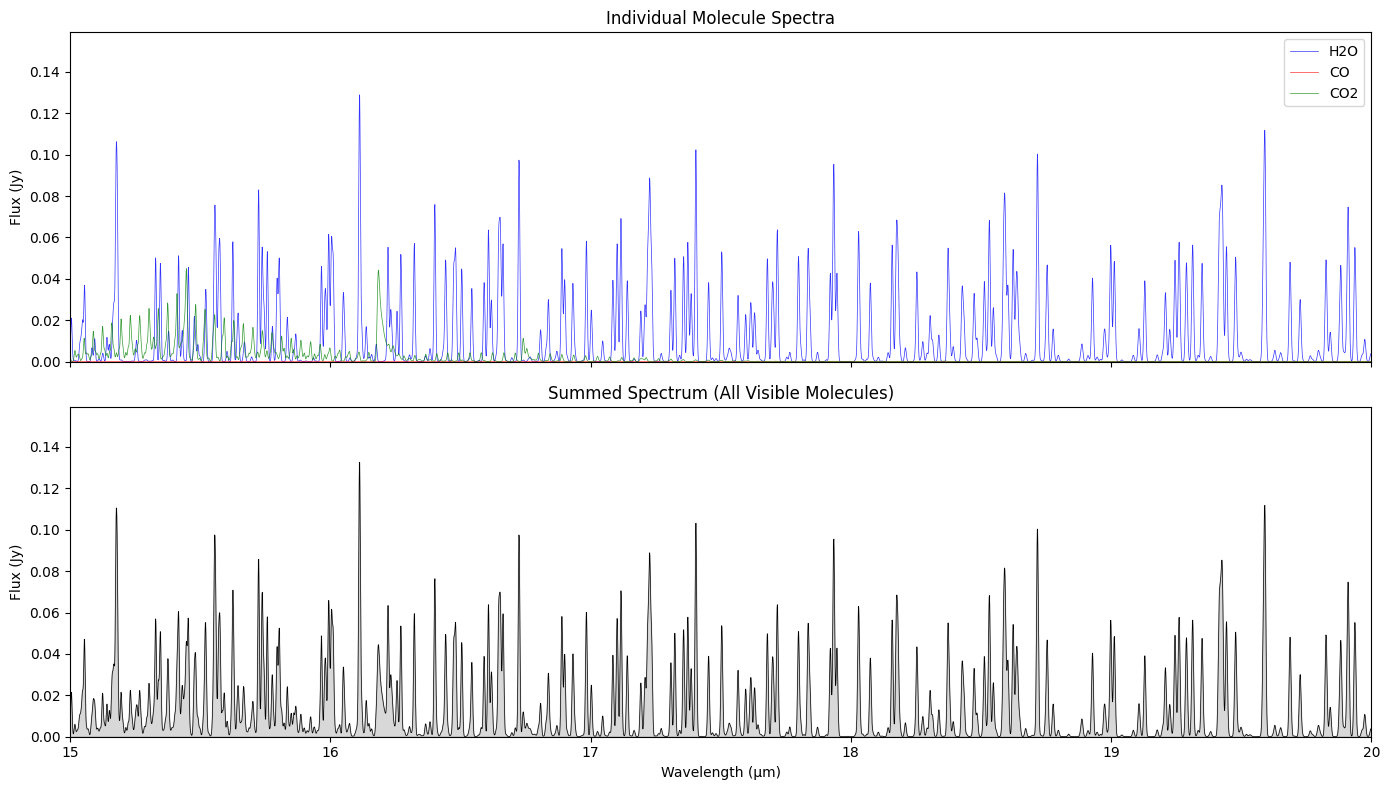

In [13]:
# Plot individual molecules and summed spectrum
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top panel: individual molecules
ax1 = axes[0]
for mol_name, mol in mol_dict.items():
    wave, flux = mol.get_flux(return_wavelengths=True)
    ax1.plot(wave, flux, color=mol.color, linewidth=0.5, label=mol.displaylabel, alpha=0.8)

ax1.set_ylabel('Flux (Jy)')
ax1.set_title('Individual Molecule Spectra')
ax1.legend(loc='upper right')
ax1.set_xlim(15, 20)
mask = (summed_wave >= 15) & (summed_wave <= 20)
ax1.set_ylim(0, np.max(summed_flux[mask])*1.2)

# Bottom panel: summed spectrum
ax2 = axes[1]
ax2.fill_between(summed_wave, 0, summed_flux, alpha=0.3, color='gray', label='Summed flux')
ax2.plot(summed_wave, summed_flux, 'k-', linewidth=0.5)
ax2.set_xlabel('Wavelength (μm)')
ax2.set_ylabel('Flux (Jy)')
ax2.set_title('Summed Spectrum (All Visible Molecules)')
ax2.set_xlim(15, 20)
mask = (summed_wave >= 15) & (summed_wave <= 20)
ax2.set_ylim(0, np.max(summed_flux[mask])*1.2)

plt.tight_layout()
plt.show()

Visible molecules: {'H2O', 'CO'}


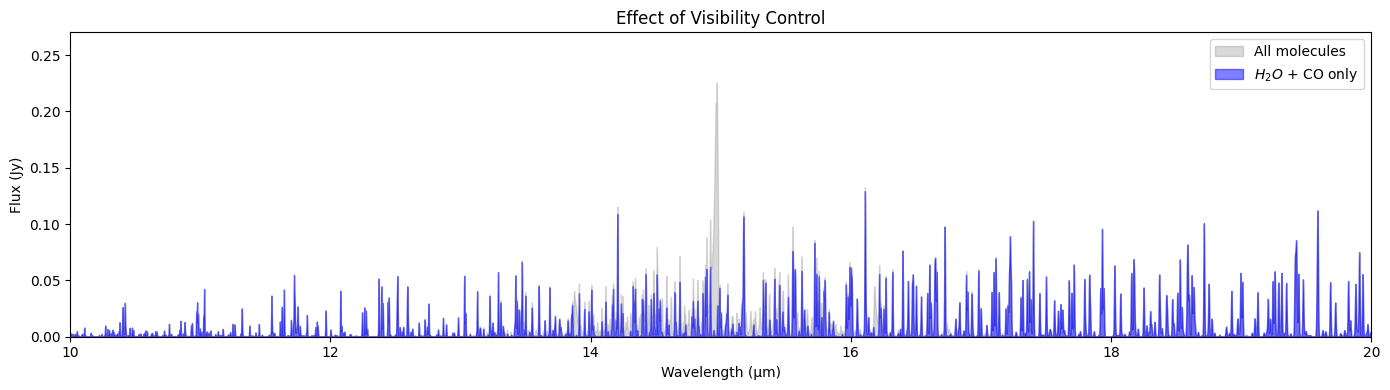

In [14]:
# Visibility control - hide CO2 and recalculate
mol_dict["CO2"].is_visible = False

visible_mols = mol_dict.get_visible_molecules()
print(f"Visible molecules: {visible_mols}")

# Get summed flux with only visible molecules
summed_wave2, summed_flux2 = mol_dict.get_summed_flux(wave_grid, visible_only=True)

# Compare
fig, ax = plt.subplots(figsize=(14, 4))
ax.fill_between(summed_wave, 0, summed_flux, alpha=0.3, color='gray', label='All molecules')
ax.fill_between(summed_wave2, 0, summed_flux2, alpha=0.5, color='blue', label='$H_2O$ + CO only')
ax.set_xlabel('Wavelength (μm)')
ax.set_ylabel('Flux (Jy)')
ax.set_title('Effect of Visibility Control')
ax.legend()
ax.set_xlim(10, 20)
mask = (summed_wave >= 10) & (summed_wave <= 20)
ax.set_ylim(0, np.max(summed_flux[mask])*1.2)

plt.tight_layout()
plt.show()

## 6. Summary

The iSLAT data types provide a powerful framework for molecular spectroscopy:

| Class | Purpose | Key Methods |
|-------|---------|-------------|
| `MoleculeLineList` | Holds HITRAN line data | `.wavelengths`, `.einsteinA`, `.energy_low` |
| `Intensity` | Calculates line intensities | `.calc_intensity()`|
| `Spectrum` | Generates convolved spectra | `.add_intensity()`, `.flux_jy`, `.lamgrid` |
| `Molecule` | High-level molecule wrapper | `.get_flux()`, `.temp`, `.n_mol`, `.radius` |
| `MoleculeDict` | Collection of molecules | `.get_summed_flux()`, `.get_visible_molecules()` |

These classes can be used independently for custom analysis workflows, or through the iSLAT GUI for interactive exploration.